
**What this notebook does:**

* Builds a clean MLP (Keras/TensorFlow) for a classification task.
* Demonstrates how to tune: number of layers / units, learning rate, batch size, dropout.
* Uses EarlyStopping and saves training histories.
* Produces validation curves (train vs val loss & accuracy) and a summary table of experiments.

---

## 1. Enable GPU in Colab

In Colab set Runtime → Change runtime type → GPU. Not required but speeds training.

---

## 2. Imports & helper functions


In [5]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product

In [6]:
# ML libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
# Dataset & preprocessing
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [8]:
# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## 3. Create synthetic dataset (easy to run anywhere)

In [5]:
# Binary classification synthetic dataset
X, y = make_classification(n_samples=10000, n_features=20, n_informative=10,
                           n_redundant=2, n_repeated=0, n_classes=2,
                           class_sep=1.0, flip_y=0.01, random_state=42)


make_classification() generates a fully artificial synthetic dataset for classification tasks.

It returns:

X → shape (10000, 20)
A NumPy array with 20 numerical features for each sample

y → shape (10000,)
The class label (0 or 1)

**n_features = 20**

Each sample has 20 input features
→ like 20 columns.

**n_informative = 10**

Out of the 20 features:

10 features truly affect the class label
These are meaningful patterns.

**n_redundant = 2**

These features are linear combinations of the informative ones.
They don’t add new info; they just copy the patterns.


**n_repeated = 0**

No duplicated columns.

**n_classes = 2**

Binary classification (label is 0 or 1)

**class_sep = 1.0**

Controls how far apart class 0 and class 1 are
• Higher → easier classification
• Lower → overlapping classes (harder)

**flip_y = 0.01**

Add 1% random label noise (to simulate real-world imperfect labels).

**random_state = 42**

Ensures SAME random data every run (for reproducibility).

In [6]:
import pandas as pd

df = pd.DataFrame(X)
df['label'] = y

df.head()


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,label
0,1.145527,-1.431231,1.343553,-2.226251,2.836266,0.393725,0.497039,-2.679342,-0.484000,0.543561,...,-3.385892,1.383486,0.848493,-2.740663,0.032651,-1.854549,-3.469541,1.938754,-1.602788,1
1,-0.398627,-4.021327,0.303138,1.891864,-1.176440,-0.494744,2.242590,4.944493,3.005969,0.696579,...,-1.516941,0.081452,-3.955249,-3.488351,3.537090,3.070008,2.241036,-2.255867,0.882113,0
2,1.373291,-0.178694,-1.590718,3.107308,0.980686,0.828572,-0.524063,0.439533,1.717222,0.720226,...,-3.646519,0.468561,-2.909754,-3.210179,-0.656369,1.337481,0.687274,-1.598358,0.365950,1
3,-0.334228,1.811195,2.606076,2.305094,-0.093021,-0.619862,1.070445,-0.912655,-2.038940,-1.243452,...,-0.877006,-1.317697,-0.485025,-1.100836,-2.959932,-0.203805,-0.222513,-0.947643,-0.275123,1
4,1.371725,-4.808889,1.564857,5.449681,-1.988532,-1.030014,0.019262,5.393165,0.067129,-1.160891,...,-0.049544,0.627094,-3.405261,0.025678,3.169422,-1.188827,-0.005081,-3.915832,-1.398771,0


In [7]:
# Train / val / test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42, stratify=y_tmp)

In [8]:
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print('Shapes:', X_train.shape, X_val.shape, X_test.shape)

Shapes: (7000, 20) (1500, 20) (1500, 20)


Normalizes (standardizes) the input features so that all features have:

mean = 0

standard deviation = 1

This is called Z-score normalization.

Why do we need to scale data?

Neural networks train better when all input features are on a similar scale.

## 4. Model builder: parametric MLP


Defines how many input features the model will receive.

Creates multiple Dense Hidden layers.

Adds dropout after each layer if dropout_rate > 0

Outputs a single value between 0 and 1.

**model = keras.Model(inputs, outputs)** Connects all layers into one model.




**model.compile()** Compile the model

Uses the Adam optimizer with your chosen learning rate.

Loss function = binary_crossentropy (because it's binary classification).

Tracks accuracy during training.

In [9]:
def build_mlp(input_shape, layer_units=(64, 32), dropout_rate=0.0, lr=1e-3):
    inputs = keras.Input(shape=(input_shape,))
    x = inputs
    for i, units in enumerate(layer_units):
        x = layers.Dense(units, activation='relu', name=f'dense_{i+1}')(x)
        if dropout_rate and dropout_rate>0:
            x = layers.Dropout(dropout_rate, name=f'dropout_{i+1}')(x)
    outputs = layers.Dense(1, activation='sigmoid', name='out')(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

## 5. Plotting learning curves helper

In [10]:
def plot_history(history, title=None):
    # history: `keras.callbacks.History` or dict-like with 'loss','val_loss','accuracy','val_accuracy'
    if isinstance(history, dict):
        h = history
    else:
        h = history.history
    epochs = range(1, len(h['loss'])+1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, h['loss'], label='train loss')
    plt.plot(epochs, h['val_loss'], label='val loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, h.get('accuracy', h.get('acc', [])), label='train acc')
    plt.plot(epochs, h.get('val_accuracy', h.get('val_acc', [])), label='val acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend()

    if title:
        plt.suptitle(title)
    plt.show()

## 6. Tuning Different Parameters

## **model=build_mlp()** then **model.fit()** then **model.evaluate()**

# Tune layer_units


layer_units decides how many neurons are in each hidden layer.
Example: (128, 64) means the model has two hidden layers:
- first layer with 128 neurons
- second layer with 64 neurons.



Training with layer_units = (64,)
Epoch 1/50
55/55 - 1s - 20ms/step - accuracy: 0.6770 - loss: 0.5983 - val_accuracy: 0.7793 - val_loss: 0.4855
Epoch 2/50
55/55 - 0s - 5ms/step - accuracy: 0.8016 - loss: 0.4442 - val_accuracy: 0.8180 - val_loss: 0.4129
Epoch 3/50
55/55 - 0s - 4ms/step - accuracy: 0.8259 - loss: 0.3898 - val_accuracy: 0.8340 - val_loss: 0.3775
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8444 - loss: 0.3549 - val_accuracy: 0.8487 - val_loss: 0.3529
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8500 - loss: 0.3378 - val_accuracy: 0.8627 - val_loss: 0.3335
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.8637 - loss: 0.3170 - val_accuracy: 0.8667 - val_loss: 0.3165
Epoch 7/50
55/55 - 0s - 4ms/step - accuracy: 0.8684 - loss: 0.3006 - val_accuracy: 0.8793 - val_loss: 0.3017
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.8793 - loss: 0.2856 - val_accuracy: 0.8860 - val_loss: 0.2895
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.8857 - loss: 0.2764 - val_accuracy: 0.8900 - 

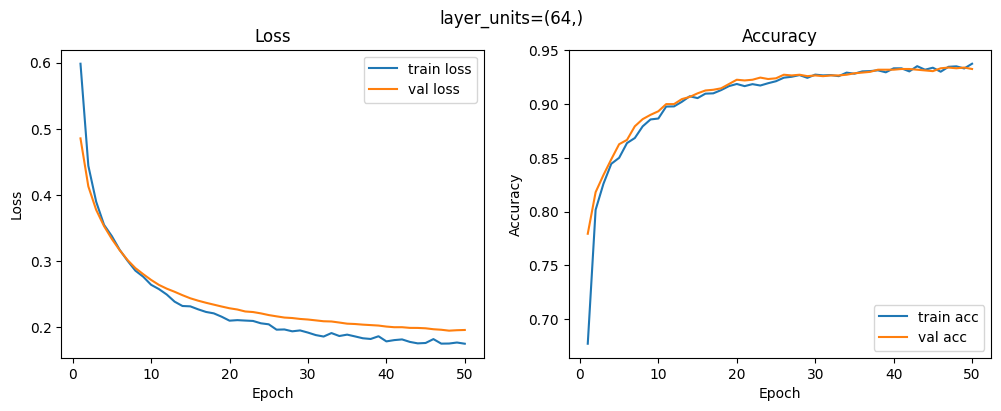


Training with layer_units = (128, 64)
Epoch 1/50
55/55 - 1s - 17ms/step - accuracy: 0.7384 - loss: 0.5106 - val_accuracy: 0.8333 - val_loss: 0.3819
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8429 - loss: 0.3513 - val_accuracy: 0.8673 - val_loss: 0.3161
Epoch 3/50
55/55 - 0s - 2ms/step - accuracy: 0.8637 - loss: 0.3045 - val_accuracy: 0.8867 - val_loss: 0.2780
Epoch 4/50
55/55 - 0s - 2ms/step - accuracy: 0.8866 - loss: 0.2680 - val_accuracy: 0.9007 - val_loss: 0.2562
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.9026 - loss: 0.2438 - val_accuracy: 0.9100 - val_loss: 0.2404
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9049 - loss: 0.2346 - val_accuracy: 0.9167 - val_loss: 0.2293
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9133 - loss: 0.2199 - val_accuracy: 0.9180 - val_loss: 0.2227
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9180 - loss: 0.2072 - val_accuracy: 0.9287 - val_loss: 0.2148
Epoch 9/50
55/55 - 0s - 2ms/step - accuracy: 0.9207 - loss: 0.2054 - val_accuracy: 0.922

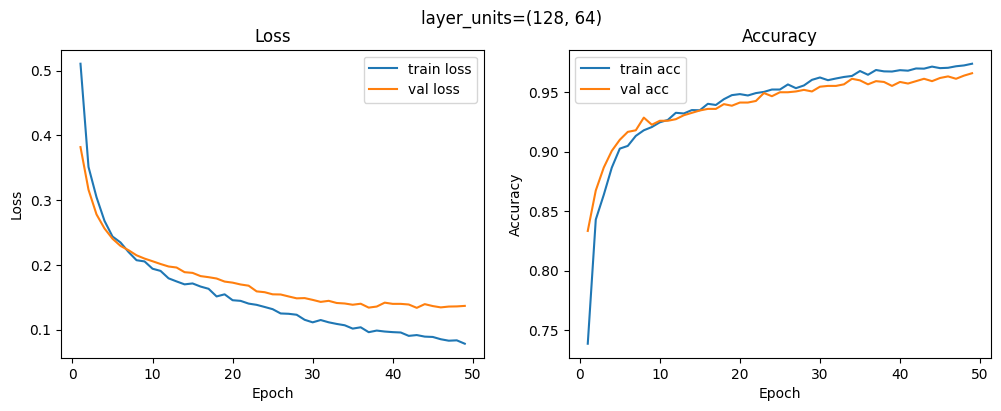

In [11]:
layer_options = [(64,), (128,64)]

for units in layer_options:
    print("\nTraining with layer_units =", units)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=units,
        dropout_rate=0.2,   # fixed
        lr=1e-3,            # fixed
        )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"layer_units={units}")


The (128, 64) architecture performs better.

It has lower validation loss (~0.13 vs ~0.19).

And higher validation accuracy (~0.965 vs ~0.945).

 The curves are smooth with no major
overfitting. Therefore, (128, 64) is the better choice.


In [12]:
best_layer_units = (128,64)   # <-- you update this


# Tune dropout_rate


Training with dropout_rate = 0.0
Epoch 1/50
55/55 - 1s - 20ms/step - accuracy: 0.7917 - loss: 0.4811 - val_accuracy: 0.8467 - val_loss: 0.3615
Epoch 2/50
55/55 - 0s - 4ms/step - accuracy: 0.8641 - loss: 0.3076 - val_accuracy: 0.8727 - val_loss: 0.3003
Epoch 3/50
55/55 - 0s - 5ms/step - accuracy: 0.8924 - loss: 0.2566 - val_accuracy: 0.8913 - val_loss: 0.2657
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.9077 - loss: 0.2248 - val_accuracy: 0.9060 - val_loss: 0.2433
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.9186 - loss: 0.2025 - val_accuracy: 0.9160 - val_loss: 0.2283
Epoch 6/50
55/55 - 0s - 4ms/step - accuracy: 0.9286 - loss: 0.1862 - val_accuracy: 0.9200 - val_loss: 0.2180
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9339 - loss: 0.1738 - val_accuracy: 0.9233 - val_loss: 0.2101
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9390 - loss: 0.1640 - val_accuracy: 0.9253 - val_loss: 0.2041
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9427 - loss: 0.1559 - val_accuracy: 0.9273 - v

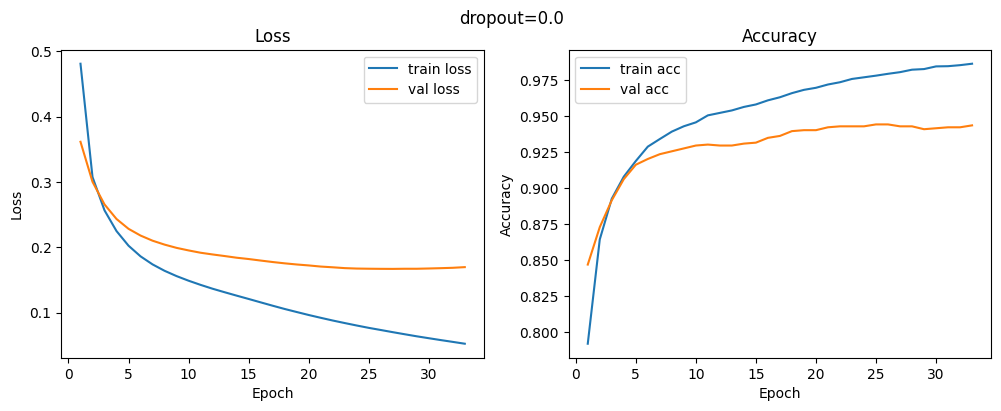


Training with dropout_rate = 0.25
Epoch 1/50
55/55 - 1s - 18ms/step - accuracy: 0.7564 - loss: 0.5073 - val_accuracy: 0.8273 - val_loss: 0.3867
Epoch 2/50
55/55 - 0s - 4ms/step - accuracy: 0.8429 - loss: 0.3515 - val_accuracy: 0.8600 - val_loss: 0.3262
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8656 - loss: 0.3123 - val_accuracy: 0.8860 - val_loss: 0.2920
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8776 - loss: 0.2807 - val_accuracy: 0.8920 - val_loss: 0.2718
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8873 - loss: 0.2600 - val_accuracy: 0.9020 - val_loss: 0.2562
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9003 - loss: 0.2420 - val_accuracy: 0.9033 - val_loss: 0.2473
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9034 - loss: 0.2350 - val_accuracy: 0.9087 - val_loss: 0.2389
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9087 - loss: 0.2261 - val_accuracy: 0.9167 - val_loss: 0.2287
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9113 - loss: 0.2182 - val_accuracy: 0.9193 - 

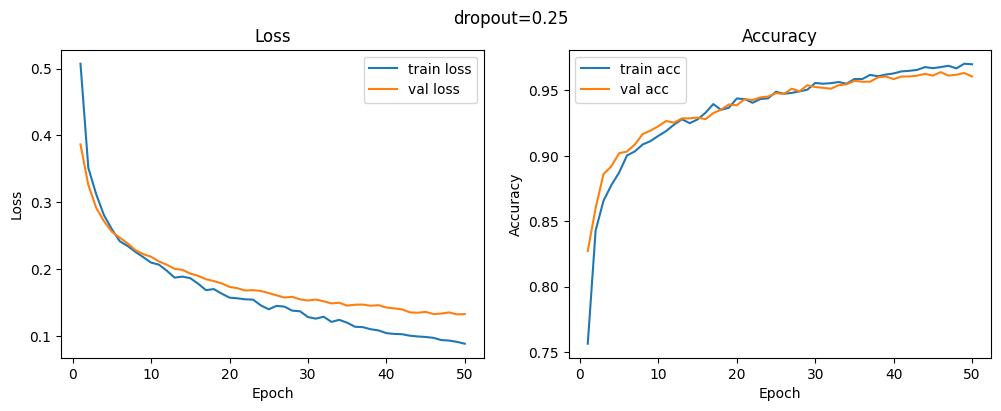


Training with dropout_rate = 0.5
Epoch 1/50
55/55 - 1s - 18ms/step - accuracy: 0.6847 - loss: 0.5864 - val_accuracy: 0.8100 - val_loss: 0.4369
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.7950 - loss: 0.4414 - val_accuracy: 0.8307 - val_loss: 0.3668
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8223 - loss: 0.3874 - val_accuracy: 0.8480 - val_loss: 0.3363
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8356 - loss: 0.3548 - val_accuracy: 0.8653 - val_loss: 0.3139
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8513 - loss: 0.3333 - val_accuracy: 0.8813 - val_loss: 0.2963
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.8630 - loss: 0.3148 - val_accuracy: 0.8860 - val_loss: 0.2831
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.8723 - loss: 0.2992 - val_accuracy: 0.8940 - val_loss: 0.2733
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.8740 - loss: 0.2890 - val_accuracy: 0.8973 - val_loss: 0.2644
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.8817 - loss: 0.2797 - val_accuracy: 0.9000 - v

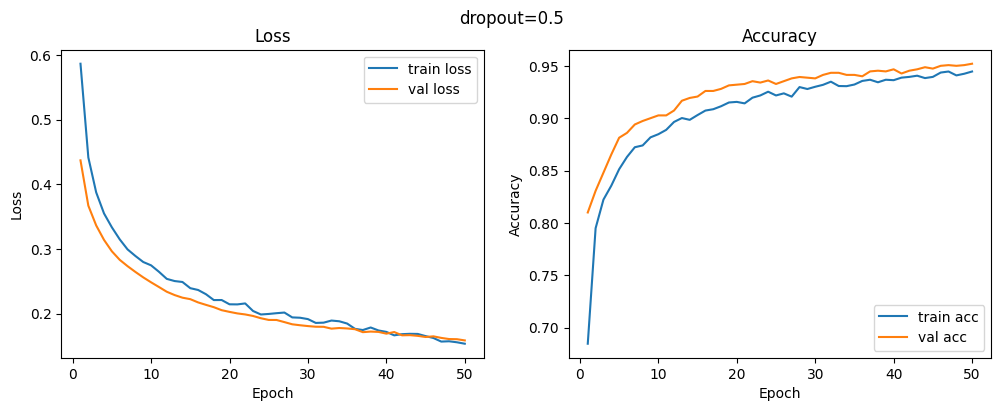

In [13]:
drop_options = [0.0, 0.25,0.5]

for d in drop_options:
    print("\nTraining with dropout_rate =", d)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=best_layer_units,
        dropout_rate=d,
        lr=1e-3
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"dropout={d}")


Patience: Wait for 6 epochs after the last improvement before stopping.

Dropout = 0.25 is the best choice because it gives the lowest validation loss, the highest validation accuracy, and shows no signs of overfitting.

Dropout=0.0 overfits slightly, while dropout=0.5 underfits the model.


In [14]:
best_dropout = 0.25

# Tune learning rate


Training with lr = 0.001
Epoch 1/50
55/55 - 1s - 18ms/step - accuracy: 0.7430 - loss: 0.5092 - val_accuracy: 0.8300 - val_loss: 0.3830
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.8406 - loss: 0.3512 - val_accuracy: 0.8627 - val_loss: 0.3197
Epoch 3/50
55/55 - 0s - 4ms/step - accuracy: 0.8641 - loss: 0.3056 - val_accuracy: 0.8787 - val_loss: 0.2877
Epoch 4/50
55/55 - 0s - 5ms/step - accuracy: 0.8797 - loss: 0.2776 - val_accuracy: 0.8927 - val_loss: 0.2656
Epoch 5/50
55/55 - 0s - 4ms/step - accuracy: 0.8933 - loss: 0.2613 - val_accuracy: 0.9013 - val_loss: 0.2486
Epoch 6/50
55/55 - 0s - 4ms/step - accuracy: 0.9030 - loss: 0.2393 - val_accuracy: 0.9120 - val_loss: 0.2369
Epoch 7/50
55/55 - 0s - 5ms/step - accuracy: 0.9076 - loss: 0.2259 - val_accuracy: 0.9160 - val_loss: 0.2263
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9156 - loss: 0.2186 - val_accuracy: 0.9227 - val_loss: 0.2187
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9200 - loss: 0.2113 - val_accuracy: 0.9233 - val_loss:

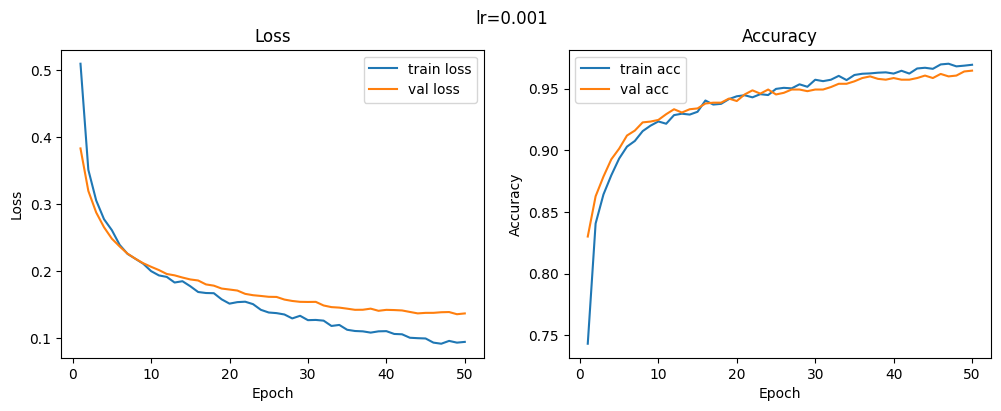


Training with lr = 0.005
Epoch 1/50
55/55 - 1s - 17ms/step - accuracy: 0.8196 - loss: 0.3844 - val_accuracy: 0.8927 - val_loss: 0.2664
Epoch 2/50
55/55 - 0s - 3ms/step - accuracy: 0.9000 - loss: 0.2461 - val_accuracy: 0.9233 - val_loss: 0.2248
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.9173 - loss: 0.2140 - val_accuracy: 0.9280 - val_loss: 0.2018
Epoch 4/50
55/55 - 0s - 2ms/step - accuracy: 0.9209 - loss: 0.1952 - val_accuracy: 0.9373 - val_loss: 0.1886
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.9323 - loss: 0.1736 - val_accuracy: 0.9440 - val_loss: 0.1798
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.9424 - loss: 0.1590 - val_accuracy: 0.9500 - val_loss: 0.1681
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.9447 - loss: 0.1554 - val_accuracy: 0.9467 - val_loss: 0.1658
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9471 - loss: 0.1426 - val_accuracy: 0.9500 - val_loss: 0.1562
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9529 - loss: 0.1338 - val_accuracy: 0.9573 - val_loss:

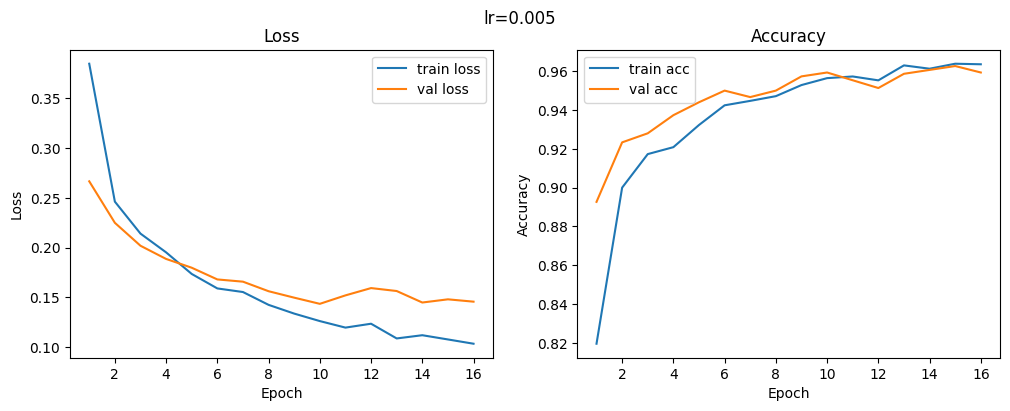

In [15]:
lr_options = [1e-3, 5e-3]

for lr in lr_options:
    print("\nTraining with lr =", lr)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=best_layer_units,
        dropout_rate=best_dropout,
        lr=lr
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=128,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"lr={lr}")


lr = 0.001 performs better. It gives smoother loss curves, lower validation loss, higher
stability, and better generalization.

lr = 0.005 learns faster but becomes noisy and stops early,
so it is less reliable.

 Therefore, lr = 0.001 is the best learning rate.


In [16]:
best_lr = 1e-3

# Tune batch_size


Training with batch_size = 32
Epoch 1/50
219/219 - 1s - 6ms/step - accuracy: 0.8051 - loss: 0.4120 - val_accuracy: 0.8707 - val_loss: 0.3102
Epoch 2/50
219/219 - 0s - 2ms/step - accuracy: 0.8730 - loss: 0.2894 - val_accuracy: 0.8940 - val_loss: 0.2622
Epoch 3/50
219/219 - 0s - 2ms/step - accuracy: 0.8970 - loss: 0.2535 - val_accuracy: 0.9067 - val_loss: 0.2407
Epoch 4/50
219/219 - 0s - 2ms/step - accuracy: 0.9067 - loss: 0.2301 - val_accuracy: 0.9153 - val_loss: 0.2255
Epoch 5/50
219/219 - 0s - 2ms/step - accuracy: 0.9116 - loss: 0.2204 - val_accuracy: 0.9200 - val_loss: 0.2122
Epoch 6/50
219/219 - 0s - 2ms/step - accuracy: 0.9213 - loss: 0.1997 - val_accuracy: 0.9247 - val_loss: 0.2058
Epoch 7/50
219/219 - 0s - 1ms/step - accuracy: 0.9277 - loss: 0.1848 - val_accuracy: 0.9273 - val_loss: 0.2007
Epoch 8/50
219/219 - 0s - 2ms/step - accuracy: 0.9347 - loss: 0.1769 - val_accuracy: 0.9333 - val_loss: 0.1867
Epoch 9/50
219/219 - 0s - 2ms/step - accuracy: 0.9347 - loss: 0.1716 - val_accura

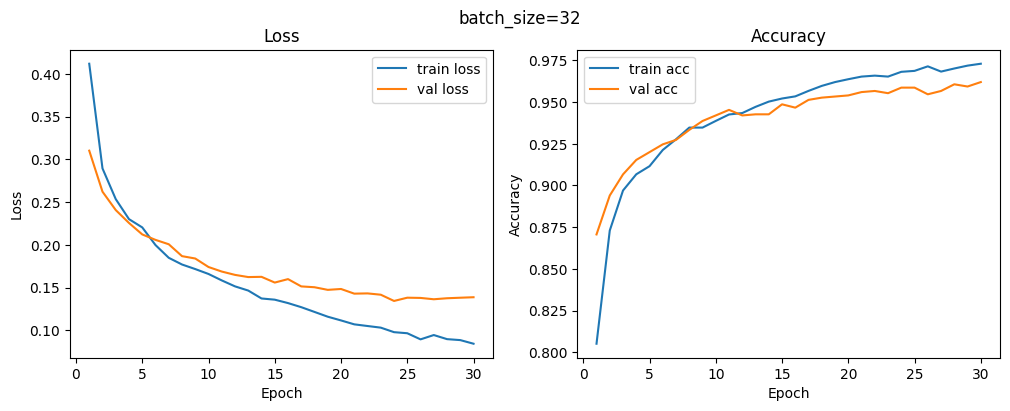


Training with batch_size = 64
Epoch 1/50
110/110 - 1s - 10ms/step - accuracy: 0.7854 - loss: 0.4591 - val_accuracy: 0.8380 - val_loss: 0.3481
Epoch 2/50
110/110 - 0s - 2ms/step - accuracy: 0.8584 - loss: 0.3258 - val_accuracy: 0.8813 - val_loss: 0.2872
Epoch 3/50
110/110 - 0s - 2ms/step - accuracy: 0.8829 - loss: 0.2763 - val_accuracy: 0.9000 - val_loss: 0.2569
Epoch 4/50
110/110 - 0s - 2ms/step - accuracy: 0.8980 - loss: 0.2548 - val_accuracy: 0.9127 - val_loss: 0.2393
Epoch 5/50
110/110 - 0s - 2ms/step - accuracy: 0.9080 - loss: 0.2316 - val_accuracy: 0.9167 - val_loss: 0.2260
Epoch 6/50
110/110 - 0s - 2ms/step - accuracy: 0.9116 - loss: 0.2195 - val_accuracy: 0.9200 - val_loss: 0.2158
Epoch 7/50
110/110 - 0s - 2ms/step - accuracy: 0.9191 - loss: 0.2073 - val_accuracy: 0.9253 - val_loss: 0.2082
Epoch 8/50
110/110 - 0s - 2ms/step - accuracy: 0.9207 - loss: 0.2048 - val_accuracy: 0.9280 - val_loss: 0.2015
Epoch 9/50
110/110 - 0s - 2ms/step - accuracy: 0.9301 - loss: 0.1901 - val_accur

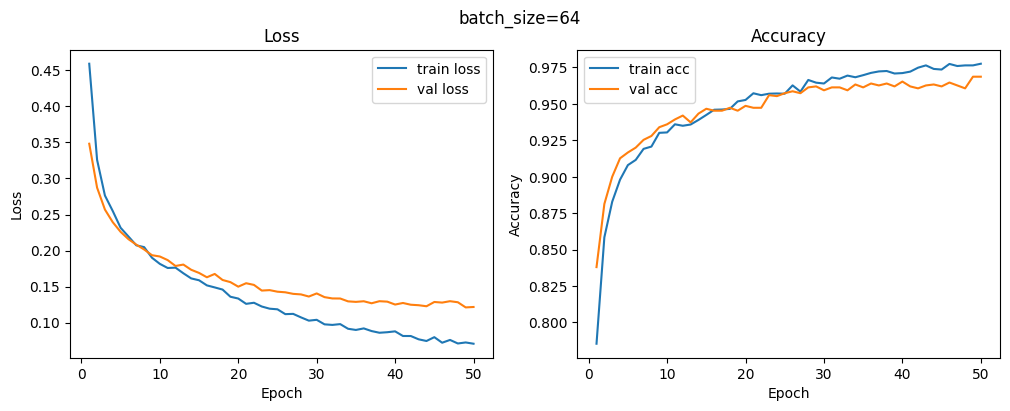


Training with batch_size = 128
Epoch 1/50
55/55 - 1s - 17ms/step - accuracy: 0.7214 - loss: 0.5451 - val_accuracy: 0.8193 - val_loss: 0.4067
Epoch 2/50
55/55 - 0s - 4ms/step - accuracy: 0.8361 - loss: 0.3728 - val_accuracy: 0.8520 - val_loss: 0.3342
Epoch 3/50
55/55 - 0s - 3ms/step - accuracy: 0.8520 - loss: 0.3296 - val_accuracy: 0.8740 - val_loss: 0.3003
Epoch 4/50
55/55 - 0s - 3ms/step - accuracy: 0.8704 - loss: 0.2940 - val_accuracy: 0.8840 - val_loss: 0.2771
Epoch 5/50
55/55 - 0s - 3ms/step - accuracy: 0.8806 - loss: 0.2702 - val_accuracy: 0.8947 - val_loss: 0.2595
Epoch 6/50
55/55 - 0s - 3ms/step - accuracy: 0.8933 - loss: 0.2481 - val_accuracy: 0.9027 - val_loss: 0.2452
Epoch 7/50
55/55 - 0s - 3ms/step - accuracy: 0.8957 - loss: 0.2435 - val_accuracy: 0.9113 - val_loss: 0.2348
Epoch 8/50
55/55 - 0s - 3ms/step - accuracy: 0.9077 - loss: 0.2279 - val_accuracy: 0.9140 - val_loss: 0.2262
Epoch 9/50
55/55 - 0s - 3ms/step - accuracy: 0.9140 - loss: 0.2209 - val_accuracy: 0.9207 - val

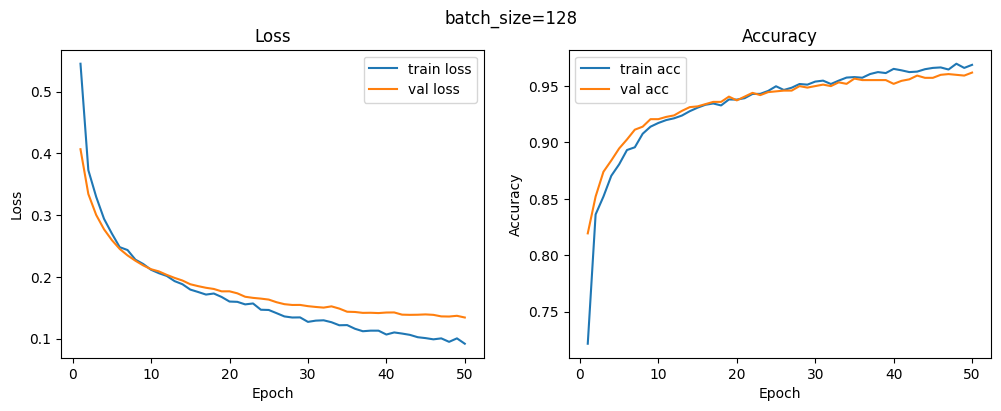

In [17]:
batch_options = [32, 64, 128]

for b in batch_options:
    print("\nTraining with batch_size =", b)

    model = build_mlp(
        input_shape=X_train.shape[1],
        layer_units=best_layer_units,
        dropout_rate=best_dropout,
        lr=best_lr
    )

    es = keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=6,
        restore_best_weights=True, verbose=1
    )

    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=50,
        batch_size=b,
        callbacks=[es],
        verbose=2
    )

    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss:", test_loss, "Test Acc:", test_acc)

    plot_history(hist, title=f"batch_size={b}")


Batch size 64 also looks good, but batch size 128 is better overall.

It has lower validation loss, higher or equal validation accuracy,
and much smoother, more stable training curves.

Batch 64 shows more noise and slightly worse generalization.

 Therefore, batch_size=128 is the best choice.


In [18]:
best_batch = 128

# 7. Final Training with all chosen hyperparameters

Training final model with:
layers = (128, 64)
dropout = 0.25
lr = 0.001
batch = 128
Epoch 1/200
55/55 - 1s - 18ms/step - accuracy: 0.7423 - loss: 0.5183 - val_accuracy: 0.8193 - val_loss: 0.3992
Epoch 2/200
55/55 - 0s - 3ms/step - accuracy: 0.8350 - loss: 0.3718 - val_accuracy: 0.8540 - val_loss: 0.3328
Epoch 3/200
55/55 - 0s - 3ms/step - accuracy: 0.8576 - loss: 0.3184 - val_accuracy: 0.8780 - val_loss: 0.2914
Epoch 4/200
55/55 - 0s - 3ms/step - accuracy: 0.8781 - loss: 0.2821 - val_accuracy: 0.8980 - val_loss: 0.2611
Epoch 5/200
55/55 - 0s - 3ms/step - accuracy: 0.8947 - loss: 0.2561 - val_accuracy: 0.9080 - val_loss: 0.2407
Epoch 6/200
55/55 - 0s - 3ms/step - accuracy: 0.9030 - loss: 0.2365 - val_accuracy: 0.9173 - val_loss: 0.2294
Epoch 7/200
55/55 - 0s - 3ms/step - accuracy: 0.9099 - loss: 0.2250 - val_accuracy: 0.9213 - val_loss: 0.2184
Epoch 8/200
55/55 - 0s - 3ms/step - accuracy: 0.9140 - loss: 0.2153 - val_accuracy: 0.9240 - val_loss: 0.2122
Epoch 9/200
55/55 - 0s - 3ms/step -

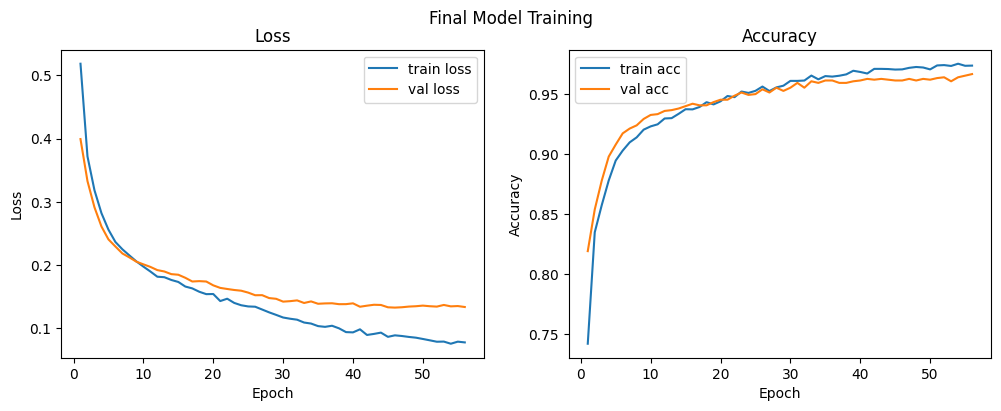

In [19]:
print("Training final model with:")
print("layers =", best_layer_units)
print("dropout =", best_dropout)
print("lr =", best_lr)
print("batch =", best_batch)

model = build_mlp(
    input_shape=X_train.shape[1],
    layer_units=best_layer_units,
    dropout_rate=best_dropout,
    lr=best_lr
)

es = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=10,
    restore_best_weights=True, verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=best_batch,
    callbacks=[es],
    verbose=2
)

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("\nFinal Test Loss:", test_loss)
print("Final Test Acc:", test_acc)

plot_history(history, title="Final Model Training")


## 8. Tips & next steps


* If validation curves show **overfitting** (train loss much lower than val loss): increase dropout, add L2 regularization, or gather more data.

* If model **underfits** (both losses high, accuracy low): increase model capacity (more units/layers), train longer (more epochs), or reduce regularization.
